In [1]:
import sys
import os

# Add the path to `database_scripts` folder
sys.path.append(os.path.abspath("../database_scripts"))
import  db_utils as du
import create_tables as ct


conn = ct.create_or_open_database()
df_fahrrad_Zähler = du.fetch_data_df('Standorten_Zählstelle',conn)
df_mess_Fahrrad= du.fetch_data_df('Messdaten_Fahrrad',conn)
df_bezirke= du.fetch_data_df('Bezirke',conn)
df_date = du.fetch_data_df('Date_dim',conn)
df_time = du.fetch_data_df('Time_dim',conn)
df_wetter = du.fetch_data_df('Wetter',conn)

Establish SQLite connection.


In [2]:
#type conversion inside the dataframe
df_time['TimeID'] = df_time['TimeID'].astype('int')
df_date['DateID'] = df_date['DateID'].astype('int')
df_wetter['TimeID'] = df_wetter['TimeID'].astype('int')
df_wetter['DateID'] = df_wetter['DateID'].astype('int32')
df_date['year'] = df_date['year'].astype('int')
df_date['month'] = df_date['month'].astype('int')
df_date['day'] = df_date['day'].astype('int')
df_date['is_holiday'] = df_date['is_holiday'].astype('bool')
df_date['quarter'] = df_date['quarter'].astype('int')
df_mess_Fahrrad['TimeID'] = df_mess_Fahrrad['TimeID'].astype('int')
df_mess_Fahrrad['DateID'] = df_mess_Fahrrad['DateID'].astype('int')
#df_mess_Fahrrad['Wert'] = df_mess_Fahrrad['Wert'].astype('int32')

df_wetter['temperature_2m (°C)'] = df_wetter['temperature_2m (°C)'].astype('float32')
df_wetter['relative_humidity_2m (%)'] = df_wetter['relative_humidity_2m (%)'].astype('float32')
df_wetter['rain (mm)'] = df_wetter['rain (mm)'].astype('float32')
df_wetter['snowfall (cm)'] = df_wetter['snowfall (cm)'].astype('float32')
df_wetter['cloud_cover (%)'] = df_wetter['cloud_cover (%)'].astype('float32')


In [3]:
#Feature Engineering:
#add a new colum for Zählstelle to be converted to number
df_fahrrad_Zähler['Zählstelle_ID'] = range(0, df_fahrrad_Zähler.shape[0])
df_fahrrad_Zähler['Zählstelle_ID'] = df_fahrrad_Zähler['Zählstelle_ID'].astype('int')
df_bezirke['Bezirk_ID'] =  range(0, df_bezirke.shape[0])
df_bezirke['Bezirk_ID'] = df_bezirke['Bezirk_ID'].astype('int')

def time_of_the_day_as_number(time_of_the_day):
    if time_of_the_day == 'nachts': 
        return 0
    if time_of_the_day == 'morgens':
        return 1
    if time_of_the_day == 'vormittags':
        return 2
    if time_of_the_day == 'mittags':
        return 3
    if time_of_the_day == 'nachmittags':
        return 4
    else:
        return 5
df_time['timeoftheday']=df_time['time_of_the_day'].apply(time_of_the_day_as_number)
df_time['timeoftheday'] = df_time['timeoftheday'].astype('int')

In [4]:
df_merged = df_bezirke.merge(df_fahrrad_Zähler, on='Bezirk', how='left')
df_merged = df_merged.merge(df_mess_Fahrrad, on='Zählstelle', how='left')
df_merged = df_merged.merge(df_wetter, on=['DateID','TimeID', 'Bezirk'], how='left')
df_merged = df_merged.merge(df_date, on='DateID', how='left')
df_merged = df_merged.merge(df_time, on='TimeID', how='left')
#print(df_merged.info())

In [5]:
df_merged.drop(['time_of_the_day','Breitengrad', 'Längengrad', 'Geometry','Bezirk','Date','Beschreibung','Installationsdatum','Zählstelle'], axis = 1, inplace= True)
from tabulate import tabulate

# Display the DataFrame as a table
print(tabulate(df_merged.head(), headers='keys', tablefmt='pretty'))

+---+-----------+---------------+--------+--------+------+---------------------+--------------------------+-----------+---------------+-----------------+--------+-------+-----+-----------------+------------+---------+--------------+
|   | Bezirk_ID | Zählstelle_ID | DateID | TimeID | Wert | temperature_2m (°C) | relative_humidity_2m (%) | rain (mm) | snowfall (cm) | cloud_cover (%) |  year  | month | day | day_of_the_week | is_holiday | quarter | timeoftheday |
+---+-----------+---------------+--------+--------+------+---------------------+--------------------------+-----------+---------------+-----------------+--------+-------+-----+-----------------+------------+---------+--------------+
| 0 |     0     |      3.0      |  1.0   |  0.0   | 4.0  | 11.199999809265137  |           71.0           |    0.0    |      0.0      |      57.0       | 2018.0 |  1.0  | 1.0 |        0        |    True    |   1.0   |     0.0      |
| 1 |     0     |      3.0      |  1.0   |  1.0   | 2.0  | 11.300000

<Axes: >

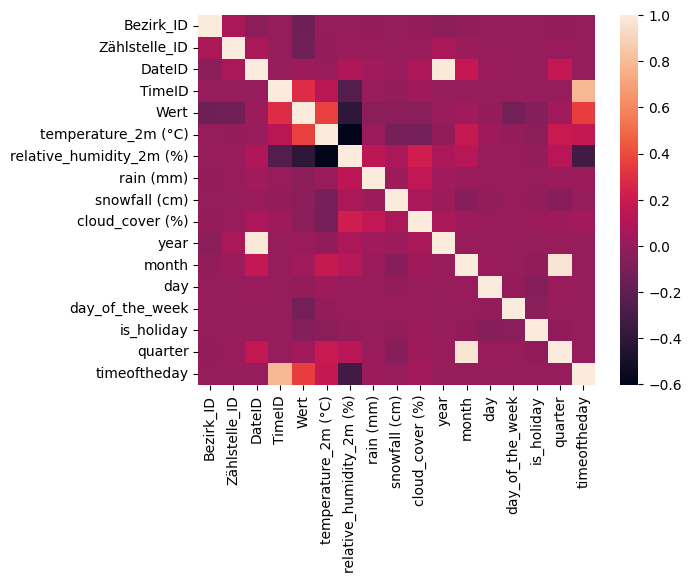

In [6]:
import seaborn as sns 
sns.heatmap(df_merged.corr())

In [7]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1413961 entries, 0 to 1413960
Data columns (total 17 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   Bezirk_ID                 1413961 non-null  int64  
 1   Zählstelle_ID             1413960 non-null  float64
 2   DateID                    1413960 non-null  float64
 3   TimeID                    1413960 non-null  float64
 4   Wert                      1413960 non-null  float64
 5   temperature_2m (°C)       1413960 non-null  float32
 6   relative_humidity_2m (%)  1413960 non-null  float32
 7   rain (mm)                 1413960 non-null  float32
 8   snowfall (cm)             1413960 non-null  float32
 9   cloud_cover (%)           1413960 non-null  float32
 10  year                      1413960 non-null  float64
 11  month                     1413960 non-null  float64
 12  day                       1413960 non-null  float64
 13  day_of_the_week           1

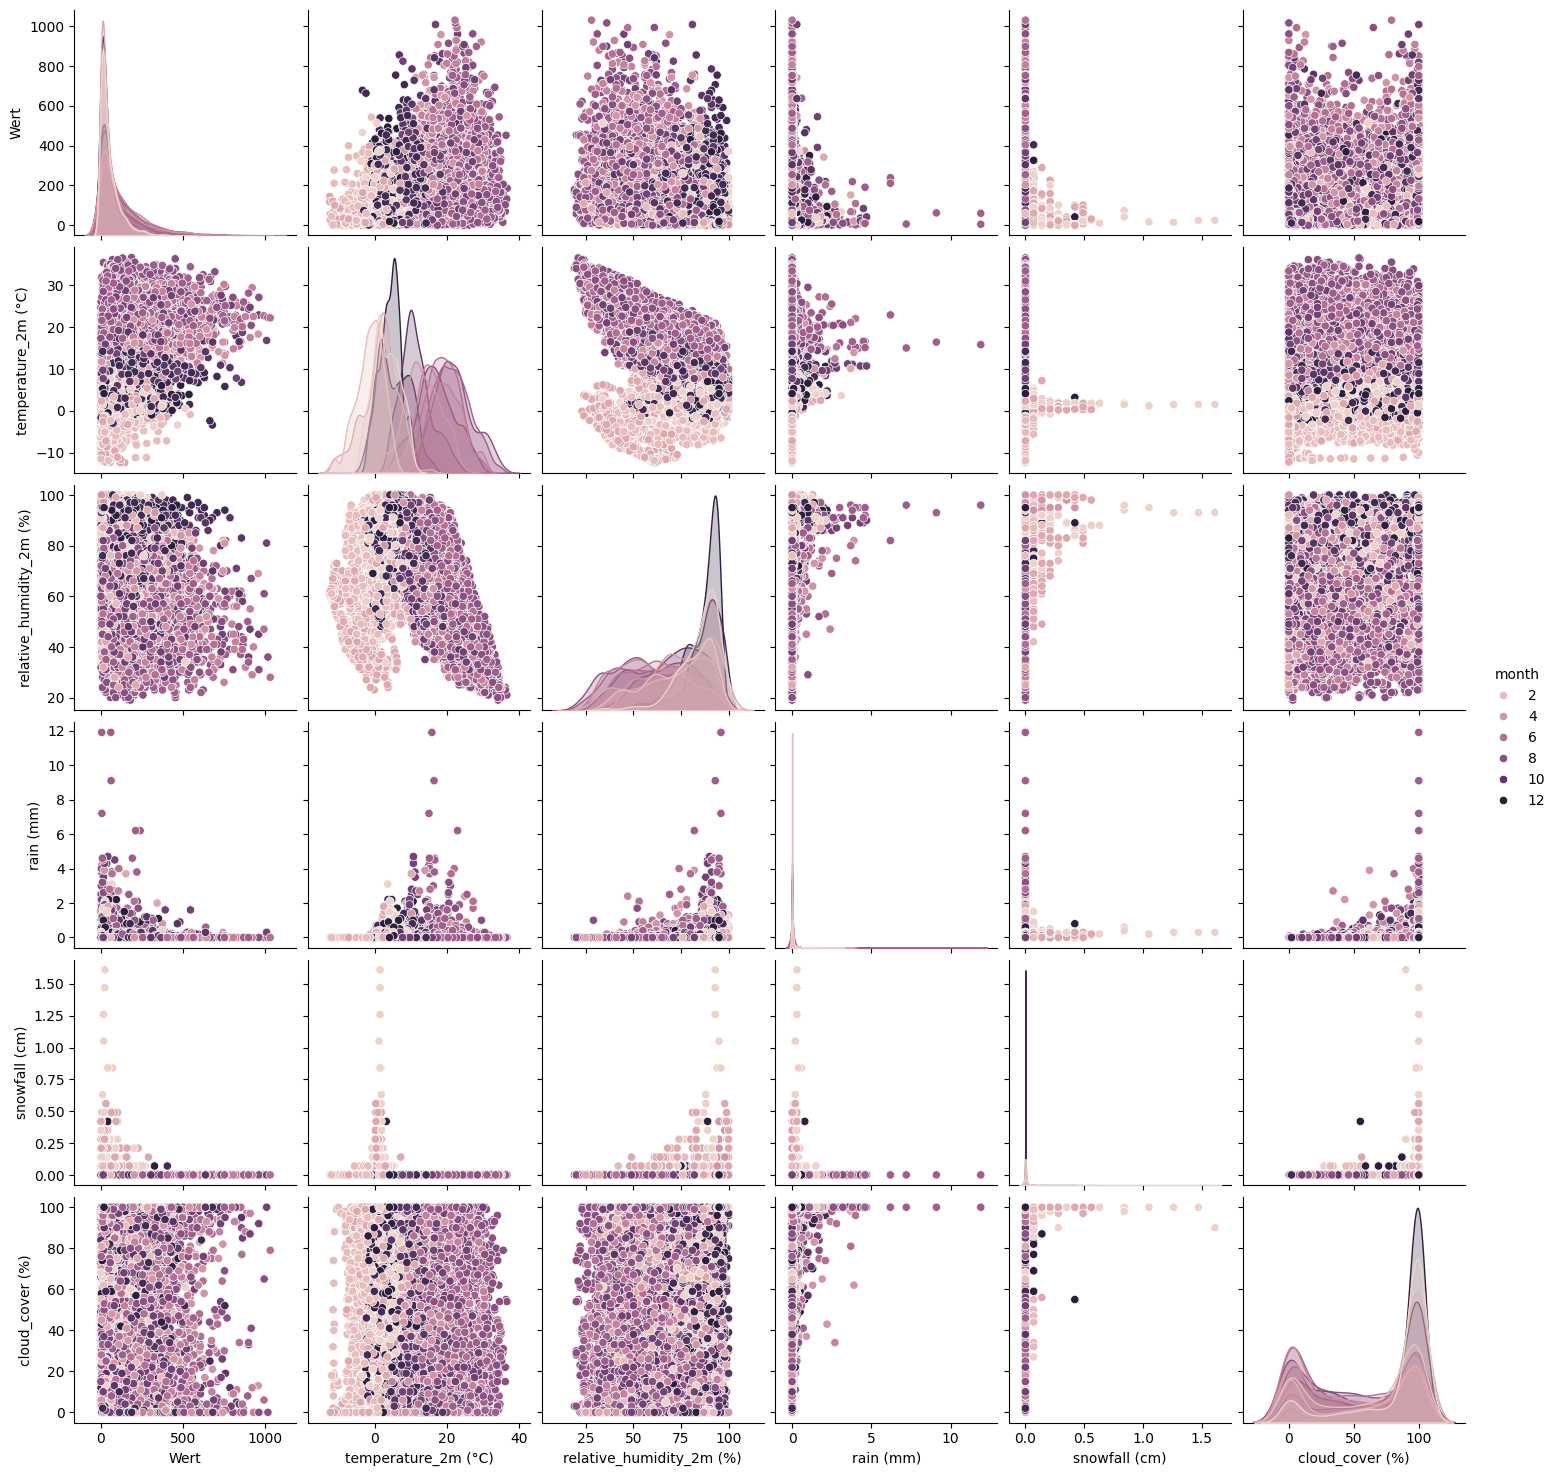

In [8]:
df_merged_2018=df_merged[df_merged['year'] == 2018]
df_sampled_2028 = df_merged_2018.sample(frac=0.1, random_state=42) 
df_merged_pairplot_Wetter =df_sampled_2028[['Wert','temperature_2m (°C)','relative_humidity_2m (%)','rain (mm)','snowfall (cm)','cloud_cover (%)','month']]
sns.pairplot(df_merged_pairplot_Wetter, hue='month')

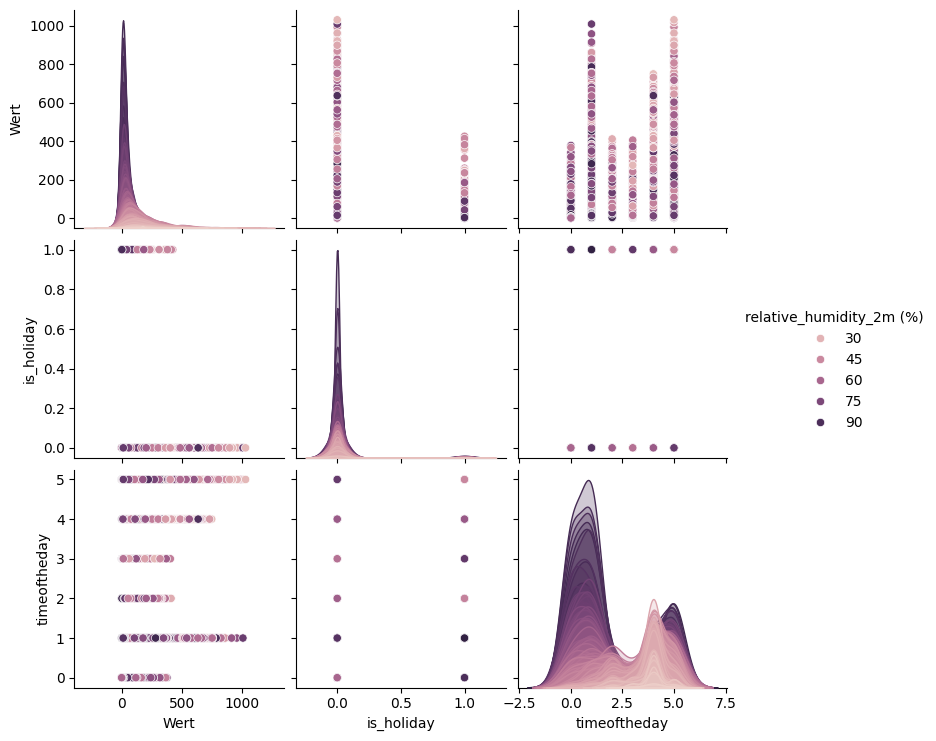

In [9]:
df_merged_pairplot_Date =df_sampled_2028[['Wert','day_of_the_week','is_holiday','timeoftheday','relative_humidity_2m (%)']]
sns.pairplot(df_merged_pairplot_Date, hue = 'relative_humidity_2m (%)')

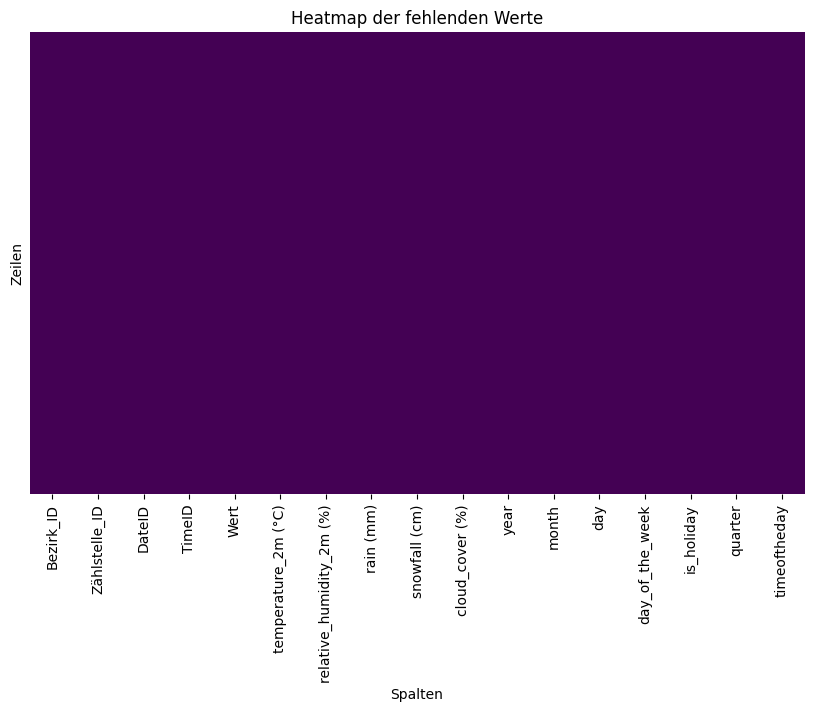

In [10]:
#show nan Werte 
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(df_merged.isna(), cbar=False, cmap='viridis',yticklabels=False)
plt.title('Heatmap der fehlenden Werte')
plt.xlabel('Spalten')
plt.ylabel('Zeilen')
plt.show()